Zinchenko+ 
https://ui.adsabs.harvard.edu/abs/2015ApJ...810...10Z/abstract

In [1]:
from astropy import units as u
distance = 1.6*u.kpc # need to update

In [2]:
from astroquery.alma import Alma

In [3]:
alma = Alma()

In [4]:
alma.login('keflavich')

INFO: Authenticating keflavich on asa.alma.cl ... [astroquery.alma.core]
INFO: Authentication successful! [astroquery.alma.core]


In [5]:
#uid://A001/X1465/X2dfe

In [6]:
import os, shutil

In [7]:
tgtdir = '/orange/adamginsburg/salt/s255ir'
if not os.path.exists(tgtdir):
    os.mkdir(tgtdir)
alma.cache_location = tgtdir
os.chdir(tgtdir)

In [8]:
# alma.query({'project_code': '2019.1.00492.S'}, public=False)

In [9]:
#alma.retrieve_data_from_uid('uid://A001/X1465/X2dfe')

In [10]:
import glob, tarfile

for fn in glob.glob("*.tar"):
    with tarfile.TarFile.open(fn) as tf:
        tf.extractall()

In [11]:
os.getcwd()

'/orange/adamginsburg/salt/s255ir'

In [12]:
%matplotlib inline
import pylab as pl
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()
pl.rcParams['figure.facecolor'] = 'w'

In [13]:
from astropy.table import Table
from astropy import table

In [14]:
import pprint

In [15]:
import scipy, scipy.ndimage

In [16]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord, visualization
import radio_beam
import pyspeckit
import pylab as pl
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

Model is linear in parameters; consider using linear fitting methods.
Model is linear in parameters; consider using linear fitting methods.


In [68]:
import regions
from astropy import units as u, coordinates
reg = regions.Regions.read('zoom.reg')
regsm = regions.Regions.read('rrlcenter.reg')
#regvsm = regions.Regions.read('verysmall.reg')
#regvvsm = regions.Regions.read('innerdiskbox.reg')

In [69]:
ls *reg

rrlcenter.reg  zoom.reg


In [70]:
ls imaging

calibrated_final_cont.ms/
calibrated_final.ms@
calibrated_final.ms.flagversions/
calibrated_final.ms.listobs
casa-20211205-041656.log
casa-20211207-135540.log
casa-20211207-135749.log
casa-20211207-140033.log
casa-20211208-020813.log
casa-20211208-021457.log
casa-20211208-022844.log
casa-20211208-023026.log
casa-20211208-025451.log
casa-20211208-030703.log
casa-20211208-031244.log
casa-20211208-031805.log
casa-20211208-134249.log
casa-20211208-164012.log
casa-20211208-175528.log
casa-20211208-222927.log
casa-20211209-200239.log
casa_log_s255ir_S255IR-SMA1_B6_12M_2021-12-04_22_24_29.log
casa_log_s255ir_S255IR-SMA1_B6_12M_2021-12-04_22_44_29.log
casa_log_s255ir_S255IR-SMA1_B6_12M_2021-12-04_23_02_46.log
casa_log_s255ir_S255IR-SMA1_B6_12M_2021-12-04_23_15_08.log
casa_log_s255ir_S255IR-SMA1_B6_12M_2021-12-04_23_22_02.log
casa_log_s255ir_S255IR-SMA1_B6_12M_2021-12-04_23_36_13.log
casa_log_s255ir_S255IR-SMA1_B6_12M_2021-12-04_23_37_57.log
casa_log_s255ir_S255IR-SMA1_B6_12M_2021-12-04_23_41_2

Select only the inner region at the apparent source of the jet, probably focused on H30a.

The broader region used for averaging, based on CH3OH, is not disky.

divide by zero encountered in long_scalars
Cube is a Stokes cube, returning spectral cube for I component


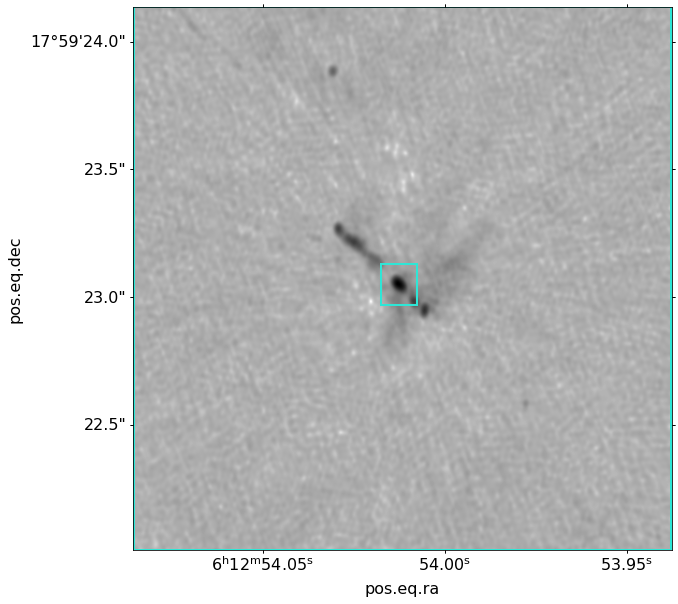

In [102]:
cont = SpectralCube.read('imaging/S255IR-SMA1_sci.spw25_27_29_31.mfs.I.manual.image.tt0.pbcor', format='casa_image').subcube_from_regions(reg)
pl.figure(figsize=(10,10))
ax = pl.subplot(projection=cont[0].wcs)
ax.imshow(cont[0].value, cmap='gray_r', norm=visualization.simple_norm(cont[0].value, stretch='log'))
reg[0].to_pixel(cont[0].wcs).plot(ax=ax)
regsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
#regvsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
#regvvsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
pp = reg[0].to_pixel(cont.wcs.celestial)
bb = pp.bounding_box
#ax.axis([bb.ixmin-20, bb.ixmax+20, bb.iymin-20, bb.iymax+20])

# Stack...

In [74]:
from spectral_cube.analysis_utilities import stack_cube

In [75]:
nacltables = salt_tables[3:5]
#nacltables[0]

In [76]:
import spectral_cube.analysis_utilities
import imp
imp.reload(spectral_cube.analysis_utilities)
from spectral_cube.analysis_utilities import stack_cube

In [77]:
flist = (glob.glob('imaging/*zoom*.image'))
flist

['imaging/S255IR-SMA1_sci.spw2.cube.I.zoom.manual.image',
 'imaging/S255IR-SMA1_sci.spw3.cube.I.zoom.manual.image',
 'imaging/S255IR-SMA1_sci.spw1.cube.I.zoom.manual.image',
 'imaging/S255IR-SMA1_sci.spw0.cube.I.zoom.manual.image']

In [78]:
filename2 = 'imaging/S255IR-SMA1_sci.spw2.cube.I.zoom.manual.image'
cube = SpectralCube.read(filename2, use_dask=True, format='casa_image')[:,100:-100,100:-100]
ch3ohcube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=216.945559*u.GHz).spectral_slab(-10*u.km/u.s, 20*u.km/u.s)
ch3ohcube = ch3ohcube - ch3ohcube.median(axis=0)
ch3ohcube

divide by zero encountered in long_scalars
Cube is a Stokes cube, returning spectral cube for I component
This function (<function BaseSpectralCube._apply_everywhere at 0x2ae291d235e0>) requires loading the entire cube into memory and may therefore be slow.


DaskVaryingResolutionSpectralCube with shape=(23, 300, 300) and unit=Jy / beam and chunk size (13, 100, 300):
 n_x:    300  type_x: RA---SIN  unit_x: deg    range:    93.224859 deg:   93.225226 deg
 n_y:    300  type_y: DEC--SIN  unit_y: deg    range:    17.989564 deg:   17.989913 deg
 n_s:     23  type_s: VRAD      unit_s: km / s  range:      -10.131 km / s:      19.556 km / s

In [149]:
cbeam = ch3ohcube.beams.common_beam()
cbeam


Beam: BMAJ=0.027334313927864142 arcsec BMIN=0.021348408846121266 arcsec BPA=-6.618228517853778 deg

In [150]:
(cbeam.major * distance).to(u.au, u.dimensionless_angles())

<Quantity 68.33578482 AU>

In [151]:
(cbeam.minor * distance).to(u.au, u.dimensionless_angles())

<Quantity 53.37102212 AU>

In [79]:
ch3oh_mx = ch3ohcube.max(axis=0)
ch3ohmsk = ch3oh_mx > 0.006*ch3ohcube.unit

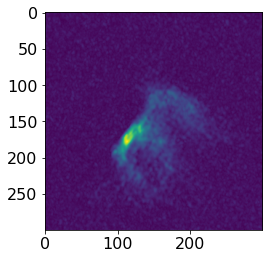

In [80]:
ch3oh_mx.quicklook()

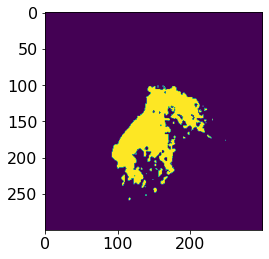

In [81]:
pl.imshow(ch3ohmsk)

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
Arithmetic beam averaging is being performed.  This is not a mathematically robust operation, but is being permitted because the beams differ by <0.01


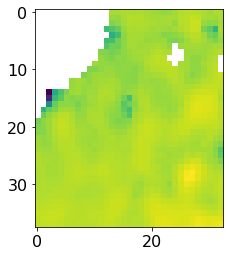

In [144]:
ch3ohcube.with_mask(ch3ohmsk).subcube_from_regions(regsm).spectral_slab(-5*u.km/u.s, 13*u.km/u.s).moment1(axis=0).quicklook()

In [124]:
#vmap = ch3ohcube.with_mask(ch3ohmsk).subcube_from_regions(regsm).spectral_slab(-5*u.km/u.s, 13*u.km/u.s).moment1(axis=0).hdu
#vmap.data[vmap.data < -5] = np.nan
#vmap.data[vmap.data > 13] = np.nan

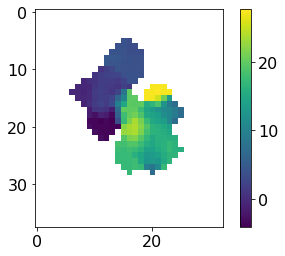

In [125]:
pl.imshow(vmap.data)
pl.colorbar()

In [126]:
sisrest = 217.81764400*u.GHz # '': 
filename2 = 'imaging/S255IR-SMA1_sci.spw2.cube.I.zoom.manual.image'
cube = SpectralCube.read(filename2, use_dask=True, format='casa_image')[:,100:-100,100:-100]
siscube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=sisrest).spectral_slab(-10*u.km/u.s, 20*u.km/u.s).subcube_from_regions(regsm)
siscube = siscube - siscube.median(axis=0)
siscube

divide by zero encountered in long_scalars
Cube is a Stokes cube, returning spectral cube for I component
This function (<function BaseSpectralCube._apply_everywhere at 0x2ae291d235e0>) requires loading the entire cube into memory and may therefore be slow.


DaskVaryingResolutionSpectralCube with shape=(23, 38, 33) and unit=Jy / beam and chunk size (23, 38, 33):
 n_x:     33  type_x: RA---SIN  unit_x: deg    range:    93.225033 deg:   93.225072 deg
 n_y:     38  type_y: DEC--SIN  unit_y: deg    range:    17.989714 deg:   17.989758 deg
 n_s:     23  type_s: VRAD      unit_s: km / s  range:      -10.006 km / s:      19.563 km / s

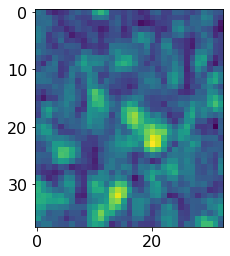

In [127]:
sis_mx = siscube.max(axis=0)
sismsk = sis_mx > 0.006*siscube.unit
sis_mx.quicklook()

In [128]:
sorest = 219.94944*u.GHz # '': 
filename2 = 'imaging/S255IR-SMA1_sci.spw3.cube.I.zoom.manual.image'
cube = SpectralCube.read(filename2, use_dask=True, format='casa_image')[:,100:-100,100:-100]
socube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=sorest).spectral_slab(-10*u.km/u.s, 20*u.km/u.s).subcube_from_regions(regsm)
socube = socube - socube.median(axis=0)
socube

divide by zero encountered in long_scalars
Cube is a Stokes cube, returning spectral cube for I component
This function (<function BaseSpectralCube._apply_everywhere at 0x2ae291d235e0>) requires loading the entire cube into memory and may therefore be slow.


DaskVaryingResolutionSpectralCube with shape=(23, 38, 33) and unit=Jy / beam and chunk size (19, 38, 33):
 n_x:     33  type_x: RA---SIN  unit_x: deg    range:    93.225033 deg:   93.225072 deg
 n_y:     38  type_y: DEC--SIN  unit_y: deg    range:    17.989714 deg:   17.989758 deg
 n_s:     23  type_s: VRAD      unit_s: km / s  range:       -9.739 km / s:      19.543 km / s

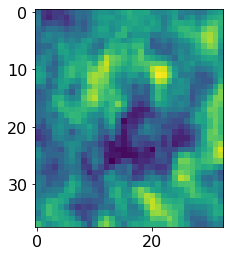

In [129]:
so_mx = socube.max(axis=0)
somsk = so_mx > 0.006*socube.unit
so_mx.quicklook()

for fn in flist:
    for rr,regn in ((reg, 'IN3'),):
        outfile = fn.replace("_small",f"_{regn}_smaller")
        if not os.path.exists(outfile):
            cube = SpectralCube.read(fn).subcube_from_regions(rr)
            cube.allow_huge_operations=True
            cb = cube.beams.common_beam(max_iter=20, max_epsilon=0.01)
            scube = cube.convolve_to(cb)
            scube.write(outfile)

regn = "IN3"
cubes = [SpectralCube.read(fn).subcube_from_regions(reg)
         for fn in (glob.glob(f'NGC_6334_I_N.config8.spw[0-3].robust0.5.image_{regn}_smaller.fits'))]

cubes

In [130]:
cubes = [SpectralCube.read(fn, use_dask=True, format='casa_image')[:,100:-100,100:-100].with_mask(ch3ohmsk)
         for fn in flist]

divide by zero encountered in long_scalars
Cube is a Stokes cube, returning spectral cube for I component
divide by zero encountered in long_scalars
Cube is a Stokes cube, returning spectral cube for I component
divide by zero encountered in long_scalars
Cube is a Stokes cube, returning spectral cube for I component
divide by zero encountered in long_scalars
Cube is a Stokes cube, returning spectral cube for I component


In [131]:
cubes = [c - c.median(axis=0) for c in cubes]

In [132]:
# only needed for VRSCs
if hasattr(cubes[0], 'beams'):
    beams = radio_beam.Beams(beams=[cube.beams.common_beam(max_iter=20, max_epsilon=0.01) for cube in cubes])
    cb=beams.common_beam()

In [133]:
linelist = np.concatenate([data['Freq'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in nacltables])
linenames = np.concatenate( [data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables] )
(linelist, linenames)

(<Quantity [217.980231, 219.614936, 221.260147, 232.509977, 234.251912] GHz>,
 array(['23Na-35Clv=2-2 J=17-16', '23Na-35Clv=1-1 J=17-16',
        '23Na-35Clv=0-0 J=17-16', '23Na-35Clv=1-1 J=18-17',
        '23Na-35Clv=0-0 J=18-17'], dtype='<U24'))

In [134]:
from astropy import log
log.setLevel('INFO')

In [33]:
#log.setLevel('DEBUG')
vcen = 2 * u.km/u.s # from jet notebook
stack, cutouts = stack_cube(cubes,
                   linelist=linelist,
                   vmin=vcen-30*u.km/u.s,
                   vmax=vcen+30*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stack.write('NaCl_v_le_3_stackcube.fits', overwrite=True)

Mean of empty slice


In [34]:
stackc = SpectralCube.read('NaCl_v_le_3_stackcube.fits')
stackc

SpectralCube with shape=(46, 300, 300) and unit=Jy / beam:
 n_x:    300  type_x: RA---SIN  unit_x: deg    range:    93.224859 deg:   93.225226 deg
 n_y:    300  type_y: DEC--SIN  unit_y: deg    range:    17.989564 deg:   17.989913 deg
 n_s:     46  type_s: VRAD      unit_s: m / s  range:   -28131.401 m / s:   32304.170 m / s

This function (<function BaseSpectralCube.max at 0x2ae291d20af0>) requires loading the entire cube into memory and may therefore be slow.
All-NaN slice encountered
invalid value encountered in true_divide
This function (<function BaseSpectralCube.argmax_world at 0x2ae291d23280>) requires loading the entire cube into memory and may therefore be slow.
This function (<function BaseSpectralCube.argmax at 0x2ae291d20e50>) requires loading the entire cube into memory and may therefore be slow.


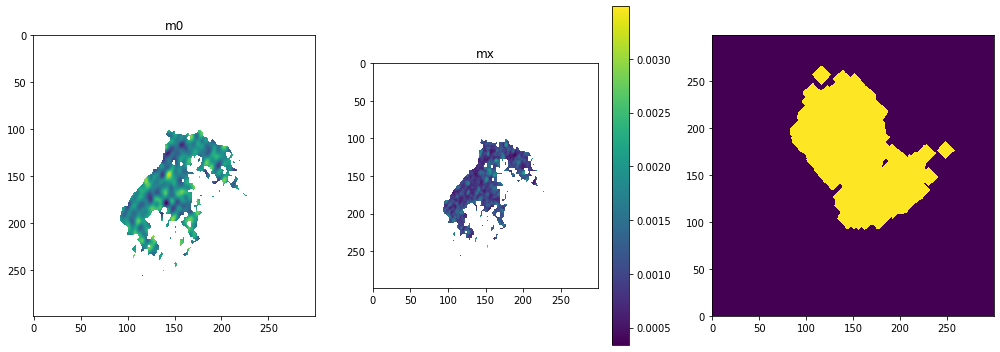

<Figure size 432x288 with 0 Axes>

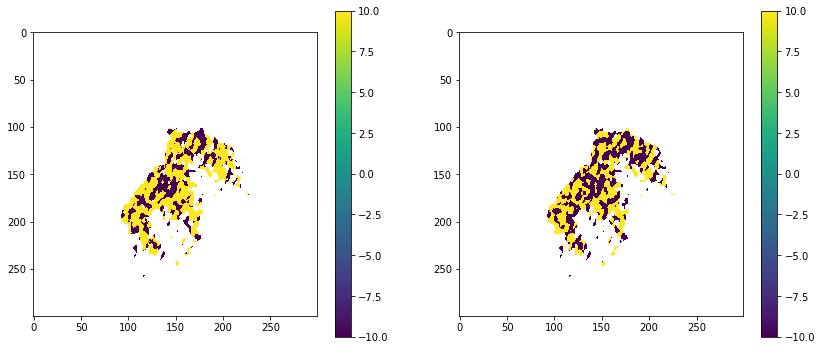

In [35]:
#stackc = stackc.subcube_from_regions(regsm)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = stackc.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = stackc.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 0.001*mx.unit
#msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=9)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()


m1 = stackc.with_mask(msk).with_mask(stackc > 0.0005*stackc.unit).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=-10, vmax=10)
pl.colorbar(mappable=im)
mxv = stackc.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=-10, vmax=10)
pl.colorbar()


#vmap = m1.hdu

In [36]:
import pvextractor
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
from show_pv import show_pv
import imp
import show_pv
imp.reload(show_pv)
from show_pv import show_keplercurves, show_pv
from astropy import coordinates, units as u

In [155]:
center = coordinates.SkyCoord(93.22505313*u.deg, 17.98973565*u.deg, frame='icrs')
PA = -45*u.deg
path = pvextractor.Path(coordinates.SkyCoord([center.directional_offset_by(PA, 0.2*u.arcsec),
                                              center.directional_offset_by(180*u.deg+PA, 0.2*u.arcsec)]))
outflowpath = pvextractor.Path(coordinates.SkyCoord([center.directional_offset_by(PA+90*u.deg, 0.4*u.arcsec),
                                              center.directional_offset_by(270*u.deg+PA, 0.4*u.arcsec)]), width=0.05*u.arcsec)

In [167]:
naclpvd = pvextractor.extract_pv_slice(stackc, path)
naclpvdoutflow = pvextractor.extract_pv_slice(stackc, outflowpath)

divide by zero encountered in long_scalars
Cube is a Stokes cube, returning spectral cube for I component


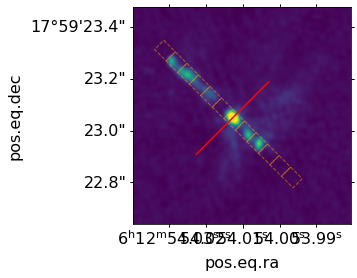

In [166]:
cont = SpectralCube.read('imaging/S255IR-SMA1_sci.spw25_27_29_31.mfs.I.manual.image.tt0.pbcor',
                        format='casa_image')[:,7900:8100,7900:8100]
ax = pl.subplot(projection=cont[0].wcs)
ax.imshow(cont[0].value, norm=visualization.simple_norm(cont[0].value, stretch='asinh', min_percent=1, max_percent=99.9))
path.show_on_axis(ax, spacing=1, color='r',)
outflowpath.show_on_axis(ax, spacing=15, edgecolor='orange', linestyle='--', alpha=0.5, facecolor='none')

leftmost: 0.0 arcsec
rightmost: 6.76666666666628e-05 arcsec
endpoints_x = [0.205 0.23 ] arcsec


divide by zero encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide


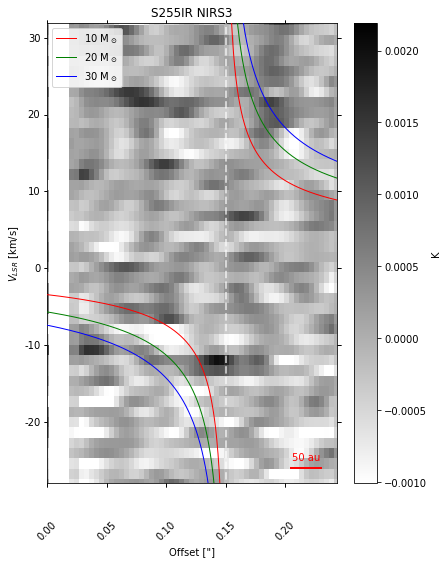

In [40]:
fig,ax,cb,con = show_pv(naclpvd.data, wcs.WCS(naclpvd.header),
                        origin=0.15*u.arcsec,
                vrange=np.array([vcen.value-30, vcen.value+30]), vcen=vcen,
                        imvmin=np.nanpercentile(naclpvd.data, 3),
                        imvmax=np.nanmax(naclpvd.data),
                        distance=distance,
                        xoffset_label=0.205*u.arcsec
                    )
cb.set_label("K")
kc = show_keplercurves(ax, 0.15*u.arcsec, 500*u.au, 
                       vcen=vcen,
                               masses=[10,20,30,],
                               linestyles=['-']*4,
                               colors=['r','g','b','c'],
                       radii={},
                       distance=2.*u.kpc,
                              )
pl.legend(loc='upper left')

pl.title("S255IR NIRS3")
pl.savefig("S255IR_naclPV_withcolorcurves.png")
#pl.legend(loc='best')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


leftmost: 2.68333333333318e-05 arcsec
rightmost: 0.0001796666666666564 arcsec
endpoints_x = [0.20502683 0.22502683] arcsec


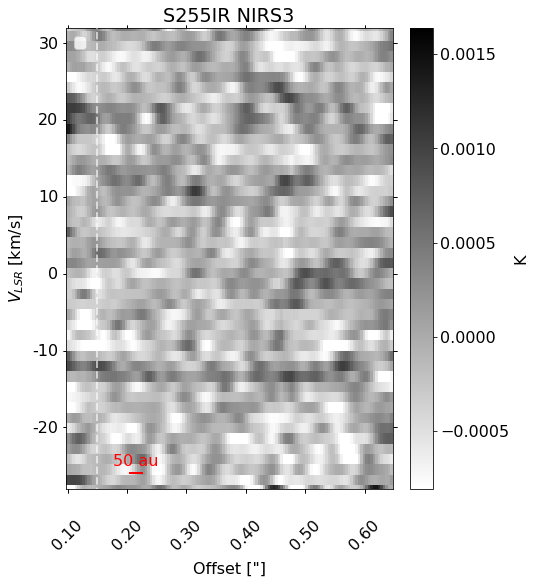

In [170]:
fig,ax,cb,con = show_pv(naclpvdoutflow.data, wcs.WCS(naclpvdoutflow.header),
                        origin=0.15*u.arcsec,
                vrange=np.array([vcen.value-30, vcen.value+30]), vcen=vcen,
                        imvmin=np.nanpercentile(naclpvdoutflow.data, 3),
                        imvmax=np.nanmax(naclpvdoutflow.data),
                        distance=distance,
                        xoffset_label=0.205*u.arcsec
                    )
cb.set_label("K")

pl.legend(loc='upper left')

pl.title("S255IR NIRS3")
pl.savefig("S255IR_naclPVoutflow.png")

In [41]:
jtok = stackc.beam.jtok(cube.with_spectral_unit(u.GHz).spectral_axis.mean())

This function (<function VaryingResolutionSpectralCube.to at 0x2ae291d2a280>) requires loading the entire cube into memory and may therefore be slow.
Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
Arithmetic beam averaging is being performed.  This is not a mathematically robust operation, but is being permitted because the beams differ by <0.01
Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
Arithmetic beam averaging is being performed.  This is not a mathematically robust operation, but is being permitted because the beams differ by <0.01
This function (<function BaseSpectralCube.argmax_world at 0x2ae291d23280>) requires loading the entire cube into memory and may therefore be slow.


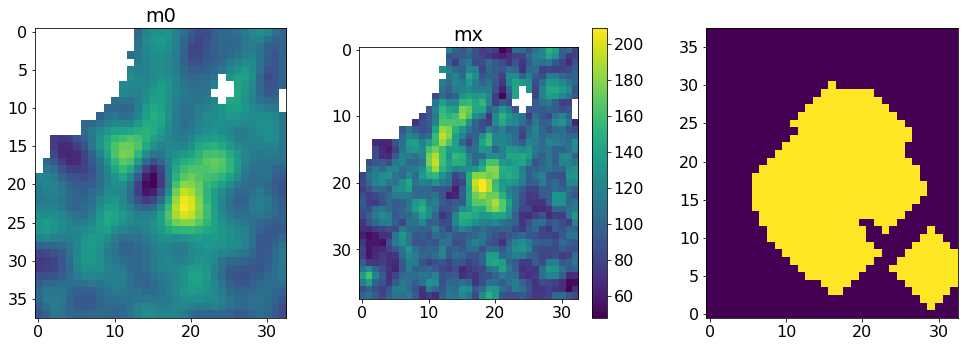

<Figure size 432x288 with 0 Axes>

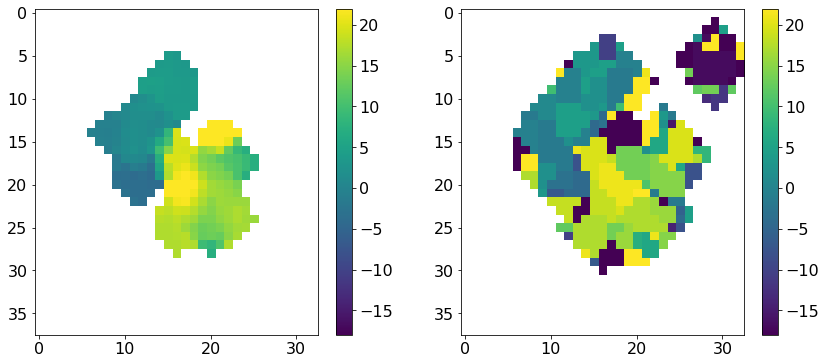

In [123]:
# try creating a vmap based on another line
restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
#scube = cube.subcube_from_regions(reg).with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=restval).spectral_slab(-20*u.km/u.s, 20*u.km/u.s)
watercube = scube = (cube
                     .subcube_from_regions(regsm)
                     .minimal_subcube()
                     .with_spectral_unit(u.km/u.s,
                                         velocity_convention='radio',
                                         rest_value=restval)
                     .spectral_slab(vcen-30*u.km/u.s, vcen+30*u.km/u.s).to(u.K))

pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 130*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()



from dask_image.ndmorph import binary_dilation, binary_erosion
m3d = (scube > 80*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
m3d = m3d.compute()


m1 = scube.with_mask(msk).with_mask(m3d).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-20, vmax=vcen.value+20)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen.value-20, vmax=vcen.value+20)
pl.colorbar()


vmap = m1.hdu

This function (<function VaryingResolutionSpectralCube.to at 0x2ae291d2a280>) requires loading the entire cube into memory and may therefore be slow.
Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
Arithmetic beam averaging is being performed.  This is not a mathematically robust operation, but is being permitted because the beams differ by <0.01
Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
Arithmetic beam averaging is being performed.  This is not a mathematically robust operation, but is being permitted because the beams differ by <0.01
This function (<function BaseSpectralCube.argmax_world at 0x2ae291d23280>) requires loading the entire cube into memory and may therefore be slow.


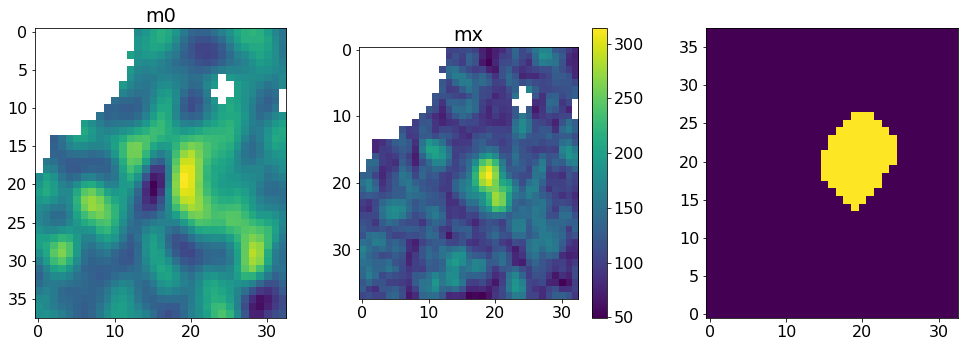

<Figure size 432x288 with 0 Axes>

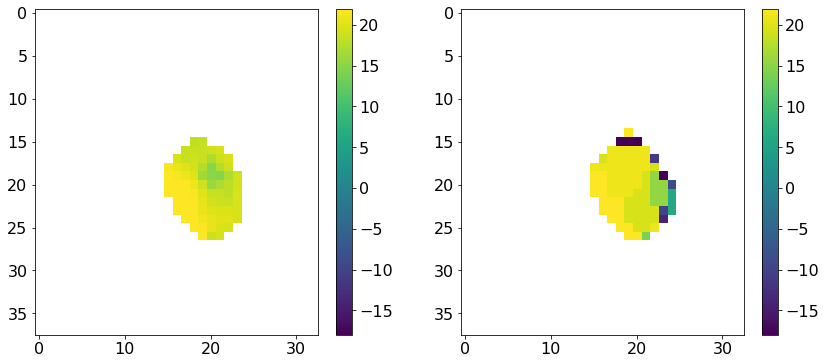

In [190]:
# try creating a vmap based on another line
restval = 217.817644*u.GHz # SiS 12-11
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
#scube = cube.subcube_from_regions(reg).with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=restval).spectral_slab(-20*u.km/u.s, 20*u.km/u.s)
siscube = scube = (cube
                     .subcube_from_regions(regsm)
                     .minimal_subcube()
                     .with_spectral_unit(u.km/u.s,
                                         velocity_convention='radio',
                                         rest_value=restval)
                     .spectral_slab(vcen-30*u.km/u.s, vcen+30*u.km/u.s).to(u.K))

pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 180*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=3)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()



from dask_image.ndmorph import binary_dilation, binary_erosion
m3d = (scube > 80*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
m3d = m3d.compute()


m1 = scube.with_mask(msk).with_mask(m3d).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-20, vmax=vcen.value+20)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen.value-20, vmax=vcen.value+20)
pl.colorbar()


#vmap = m1.hdu

In [180]:
restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
bigwatercube = (cube
                     .subcube_from_regions(reg)
                     .minimal_subcube()
                     .with_spectral_unit(u.km/u.s,
                                         velocity_convention='radio',
                                         rest_value=restval)
                     .spectral_slab(vcen-30*u.km/u.s, vcen+30*u.km/u.s).to(u.K))

waterpvd = pvextractor.extract_pv_slice(bigwatercube, path)
waterpvdoutflow = pvextractor.extract_pv_slice(bigwatercube, outflowpath)

This function (<function VaryingResolutionSpectralCube.to at 0x2ae291d2a280>) requires loading the entire cube into memory and may therefore be slow.


In [181]:
bigwatercube

DaskVaryingResolutionSpectralCube with shape=(49, 158, 157) and unit=K and chunk size (49, 99, 157):
 n_x:    157  type_x: RA---SIN  unit_x: deg    range:    93.224921 deg:   93.225113 deg
 n_y:    158  type_y: DEC--SIN  unit_y: deg    range:    17.989682 deg:   17.989865 deg
 n_s:     49  type_s: VRAD      unit_s: km / s  range:      -28.085 km / s:      32.305 km / s

leftmost: 0.0 arcsec
rightmost: 6.76666666666628e-05 arcsec
endpoints_x = [0.205 0.225] arcsec


divide by zero encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide


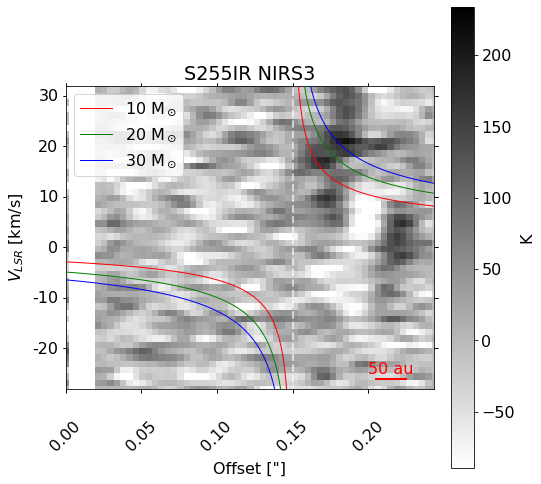

In [185]:
fig,ax,cb,con = show_pv(waterpvd.data, wcs.WCS(waterpvd.header),
                        origin=0.15*u.arcsec,
                vrange=np.array([vcen.value-30, vcen.value+30]), vcen=vcen,
                        imvmin=np.nanpercentile(waterpvd.data, 3),
                        imvmax=np.nanmax(waterpvd.data),
                        distance=distance,
                        xoffset_label=0.205*u.arcsec
                    )
cb.set_label("K")
kc = show_keplercurves(ax, 0.15*u.arcsec, 500*u.au, 
                       vcen=vcen,
                               masses=[10,20,30,],
                               linestyles=['-']*4,
                               colors=['r','g','b','c'],
                       radii={},
                       distance=distance,
                              )
pl.legend(loc='upper left')
ax.set_aspect(1)
pl.title("S255IR NIRS3")
pl.savefig("S255IR_waterPV_withcolorcurves.png")
#pl.legend(loc='best')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


leftmost: 2.68333333333318e-05 arcsec
rightmost: 0.0001796666666666564 arcsec
endpoints_x = [0.20502683 0.22502683] arcsec


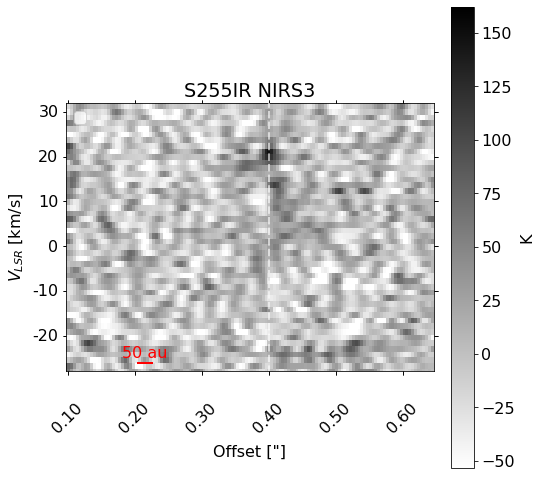

In [186]:
fig,ax,cb,con = show_pv(waterpvdoutflow.data, wcs.WCS(waterpvdoutflow.header),
                        origin=0.40*u.arcsec,
                vrange=np.array([vcen.value-30, vcen.value+30]), vcen=vcen,
                        imvmin=np.nanpercentile(waterpvdoutflow.data, 3),
                        imvmax=np.nanmax(waterpvdoutflow.data),
                        distance=distance,
                        xoffset_label=0.205*u.arcsec
                    )
cb.set_label("K")
ax.set_aspect(2)
pl.legend(loc='upper left')

pl.title("S255IR NIRS3")
pl.savefig("S255IR_waterPVoutflow.png")
#pl.legend(loc='best')

In [45]:
import sys
sys.path.append('/orange/adamginsburg/salt/code/')
from overplot_saltlines import overplot_saltlines

In [89]:
spectra = []
for ii,cube in enumerate(cubes):
    cube.allow_huge_operations=True
    sp = cube.subcube_from_regions(regsm).to(u.K).mean(axis=(1,2))
    #sp = cube.mean(axis=(1,2))
    pysp = pyspeckit.Spectrum(data=sp, xarr=sp.spectral_axis, header=sp.header)
    spectra.append(pysp)
    pysp.specname = f'spw{ii+1}'

This function (<function VaryingResolutionSpectralCube.to at 0x2ae291d2a280>) requires loading the entire cube into memory and may therefore be slow.
This function (<function VaryingResolutionSpectralCube.to at 0x2ae291d2a280>) requires loading the entire cube into memory and may therefore be slow.
This function (<function VaryingResolutionSpectralCube.to at 0x2ae291d2a280>) requires loading the entire cube into memory and may therefore be slow.
This function (<function VaryingResolutionSpectralCube.to at 0x2ae291d2a280>) requires loading the entire cube into memory and may therefore be slow.


In [90]:
mkdir -p spectra/figures

spw1
spw2
spw3
spw4


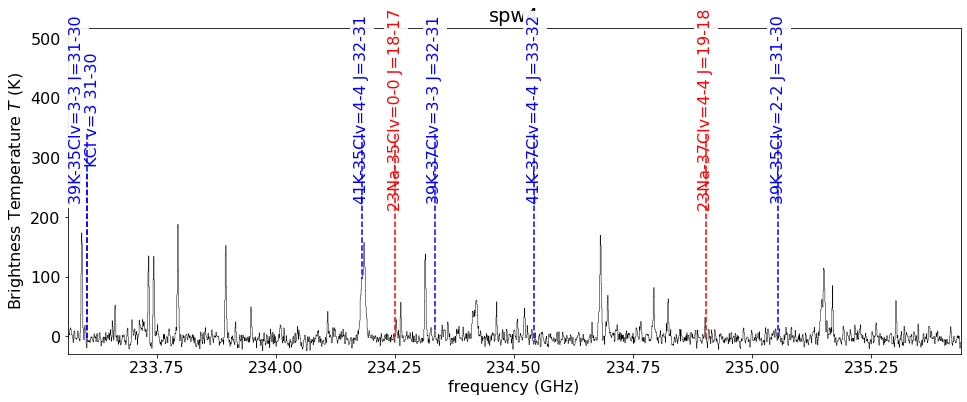

In [91]:
overplot_saltlines(spectra, vcen=vcen, savepath='spectra/figures')

In [92]:
ls spectra/figures

color_labels_S255IR-SMA1_sci_cube_stack.png
color_labels_spw1.png
color_labels_spw2.png
color_labels_spw3.png
color_labels_spw4.png
S255IR-SMA1_sci_cube_stack.png
S255IR-SMA1_sci.spw0.cube.I.zoom.manual_stack.pdf
S255IR-SMA1_sci.spw0.cube.I.zoom.manual_stack.png
S255IR-SMA1_sci.spw1.cube.I.zoom.manual_stack.pdf
S255IR-SMA1_sci.spw1.cube.I.zoom.manual_stack.png
S255IR-SMA1_sci.spw2.cube.I.zoom.manual_stack.pdf
S255IR-SMA1_sci.spw2.cube.I.zoom.manual_stack.png
S255IR-SMA1_sci.spw3.cube.I.zoom.manual_stack.pdf
S255IR-SMA1_sci.spw3.cube.I.zoom.manual_stack.png
spw1.png
spw2.png
spw3.png
spw4.png


In [93]:
from IPython.display import Image,display

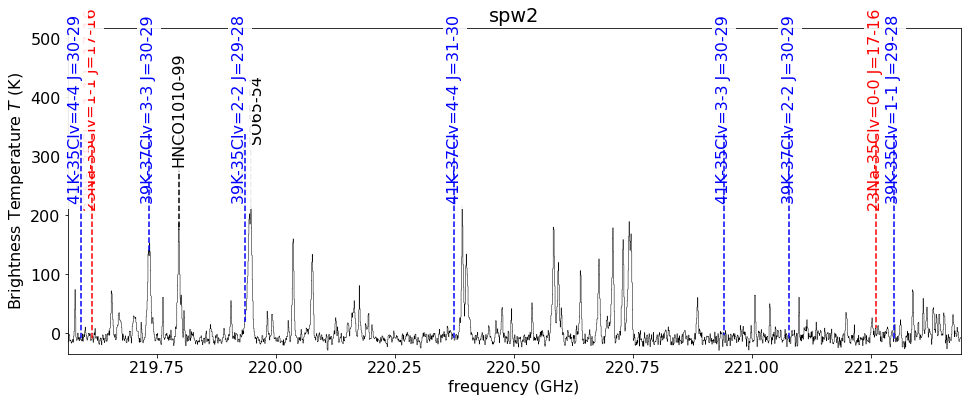

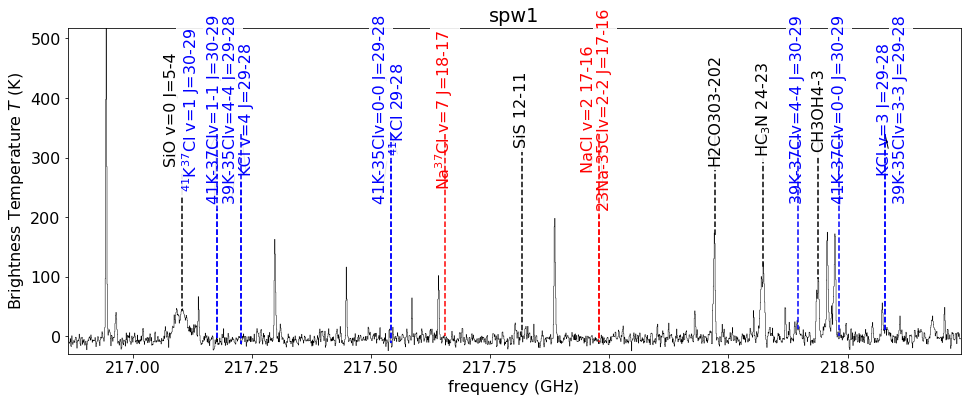

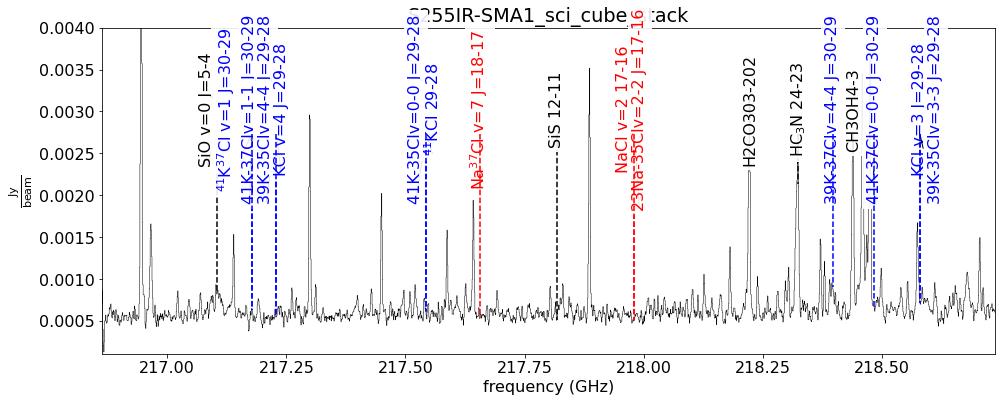

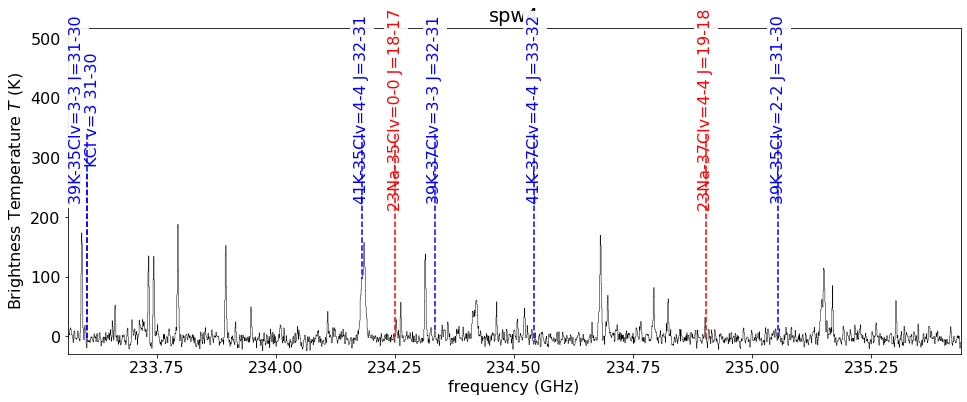

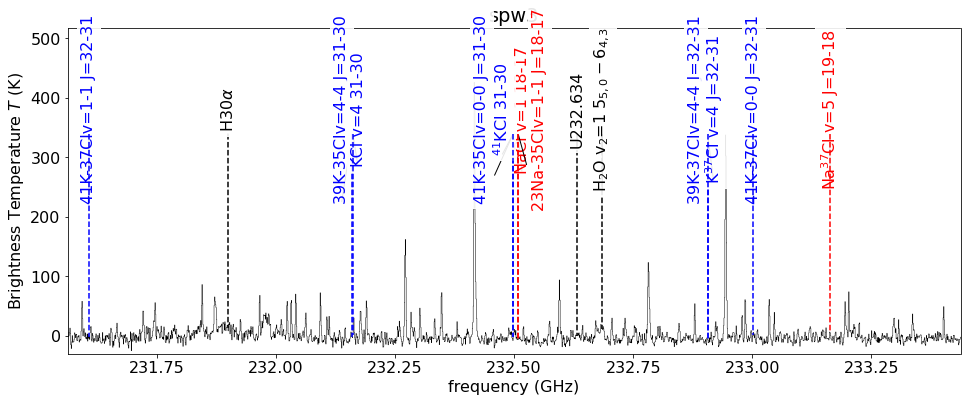

In [94]:
for fn in glob.glob('spectra/figures/color*png'):
    display(Image(fn))

divide by zero encountered in long_scalars
Cube is a Stokes cube, returning spectral cube for I component


DaskVaryingResolutionSpectralCube with shape=(1920, 300, 300) and unit=Jy / beam and chunk size (80, 100, 300):
 n_x:    300  type_x: RA---SIN  unit_x: deg    range:    93.224859 deg:   93.225226 deg
 n_y:    300  type_y: DEC--SIN  unit_y: deg    range:    17.989564 deg:   17.989913 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 216863051761.207 Hz:218736973687.894 Hz


This function (<function VaryingResolutionSpectralCube.to at 0x2ae291d2a280>) requires loading the entire cube into memory and may therefore be slow.


DaskVaryingResolutionSpectralCube with shape=(1920, 38, 33) and unit=K and chunk size (80, 38, 33):
 n_x:     33  type_x: RA---SIN  unit_x: deg    range:    93.225033 deg:   93.225072 deg
 n_y:     38  type_y: DEC--SIN  unit_y: deg    range:    17.989714 deg:   17.989758 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 216863051761.207 Hz:218736973687.894 Hz
Mean spectrum
Stacking


divide by zero encountered in long_scalars
Cube is a Stokes cube, returning spectral cube for I component


DaskVaryingResolutionSpectralCube with shape=(1920, 300, 300) and unit=Jy / beam and chunk size (80, 100, 300):
 n_x:    300  type_x: RA---SIN  unit_x: deg    range:    93.224859 deg:   93.225226 deg
 n_y:    300  type_y: DEC--SIN  unit_y: deg    range:    17.989564 deg:   17.989913 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 219563051918.890 Hz:221436973845.577 Hz


This function (<function VaryingResolutionSpectralCube.to at 0x2ae291d2a280>) requires loading the entire cube into memory and may therefore be slow.


DaskVaryingResolutionSpectralCube with shape=(1920, 38, 33) and unit=K and chunk size (80, 38, 33):
 n_x:     33  type_x: RA---SIN  unit_x: deg    range:    93.225033 deg:   93.225072 deg
 n_y:     38  type_y: DEC--SIN  unit_y: deg    range:    17.989714 deg:   17.989758 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 219563051918.890 Hz:221436973845.577 Hz
Mean spectrum
Stacking


divide by zero encountered in long_scalars
Cube is a Stokes cube, returning spectral cube for I component


DaskVaryingResolutionSpectralCube with shape=(1920, 300, 300) and unit=Jy / beam and chunk size (80, 100, 300):
 n_x:    300  type_x: RA---SIN  unit_x: deg    range:    93.224859 deg:   93.225226 deg
 n_y:    300  type_y: DEC--SIN  unit_y: deg    range:    17.989564 deg:   17.989913 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 231563052620.163 Hz:233436974546.850 Hz


This function (<function VaryingResolutionSpectralCube.to at 0x2ae291d2a280>) requires loading the entire cube into memory and may therefore be slow.


DaskVaryingResolutionSpectralCube with shape=(1920, 38, 33) and unit=K and chunk size (80, 38, 33):
 n_x:     33  type_x: RA---SIN  unit_x: deg    range:    93.225033 deg:   93.225072 deg
 n_y:     38  type_y: DEC--SIN  unit_y: deg    range:    17.989714 deg:   17.989758 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 231563052620.163 Hz:233436974546.850 Hz
Mean spectrum
Stacking


divide by zero encountered in long_scalars
Cube is a Stokes cube, returning spectral cube for I component


DaskVaryingResolutionSpectralCube with shape=(1920, 300, 300) and unit=Jy / beam and chunk size (80, 100, 300):
 n_x:    300  type_x: RA---SIN  unit_x: deg    range:    93.224859 deg:   93.225226 deg
 n_y:    300  type_y: DEC--SIN  unit_y: deg    range:    17.989564 deg:   17.989913 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 233563052737.028 Hz:235436974663.715 Hz


This function (<function VaryingResolutionSpectralCube.to at 0x2ae291d2a280>) requires loading the entire cube into memory and may therefore be slow.


DaskVaryingResolutionSpectralCube with shape=(1920, 38, 33) and unit=K and chunk size (80, 38, 33):
 n_x:     33  type_x: RA---SIN  unit_x: deg    range:    93.225033 deg:   93.225072 deg
 n_y:     38  type_y: DEC--SIN  unit_y: deg    range:    17.989714 deg:   17.989758 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 233563052737.028 Hz:235436974663.715 Hz
Mean spectrum
Stacking


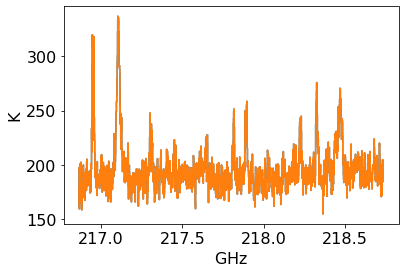

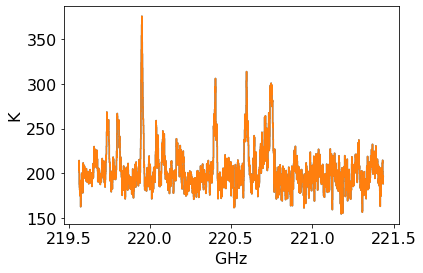

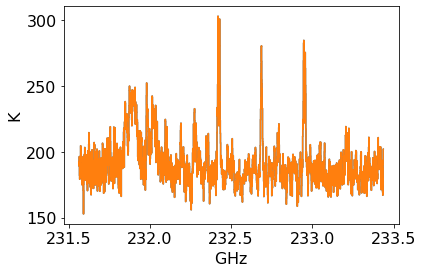

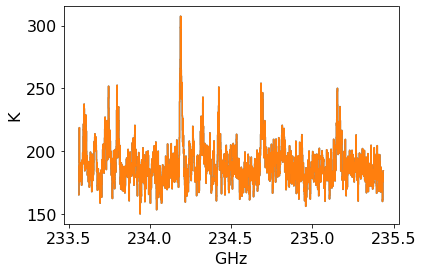

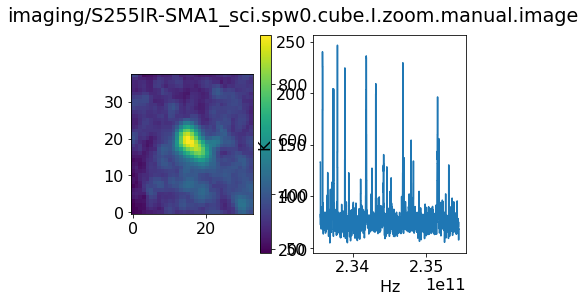

In [135]:
import glob
import spectral_cube.analysis_utilities
import reproject
from tqdm.notebook import tqdm

cbflist = (glob.glob('imaging/*zoom*.image'))
for fn in cbflist:
    basename = os.path.split(fn)[-1].split(".image")[0]
    try:
        cube = SpectralCube.read(fn, use_dask=True, format='casa_image')[:,100:-100,100:-100]
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    #scube = cube.subcube_from_regions(reg)
    scube = cube.subcube_from_regions(regsm).to(u.K).minimal_subcube(spatial_only=True)
    print(scube)
    mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    print("Mean spectrum")
    sp = scube.mean(axis=(1,2))
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".image","_meanspec.fits")}', overwrite=True)


    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)

    # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
    if scube.spectral_axis.unit.is_equivalent(u.Hz):
        scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

    print("Stacking")
    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s,
                                                           progressbar=tqdm,
                                                           chunk_size=100,
                                                           pad_edges=False,
                                                           #num_cores=8
                                                          )
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

In [97]:
ls spectra

figures/
S255IR-SMA1_sci.spw0.cube.I.zoom.manual_meanspec.fits
S255IR-SMA1_sci.spw0.cube.I.zoom.manual_stack.fits
S255IR-SMA1_sci.spw1.cube.I.zoom.manual_meanspec.fits
S255IR-SMA1_sci.spw1.cube.I.zoom.manual_stack.fits
S255IR-SMA1_sci.spw2.cube.I.zoom.manual_meanspec.fits
S255IR-SMA1_sci.spw2.cube.I.zoom.manual_stack.fits
S255IR-SMA1_sci.spw3.cube.I.zoom.manual_meanspec.fits
S255IR-SMA1_sci.spw3.cube.I.zoom.manual_stack.fits


In [140]:
stackspectra = []
for ii,fn in enumerate(glob.glob('spectra/*_stack.fits')):
    pysp = pyspeckit.Spectrum(fn)
    basename = os.path.basename(fn)
    spl = basename.split(".")
    pysp.specname = f'{spl[0]}_{spl[1]}_stack'
    stackspectra.append(pysp)

S255IR-SMA1_sci_spw0_stack
S255IR-SMA1_sci_spw3_stack
S255IR-SMA1_sci_spw1_stack
S255IR-SMA1_sci_spw2_stack


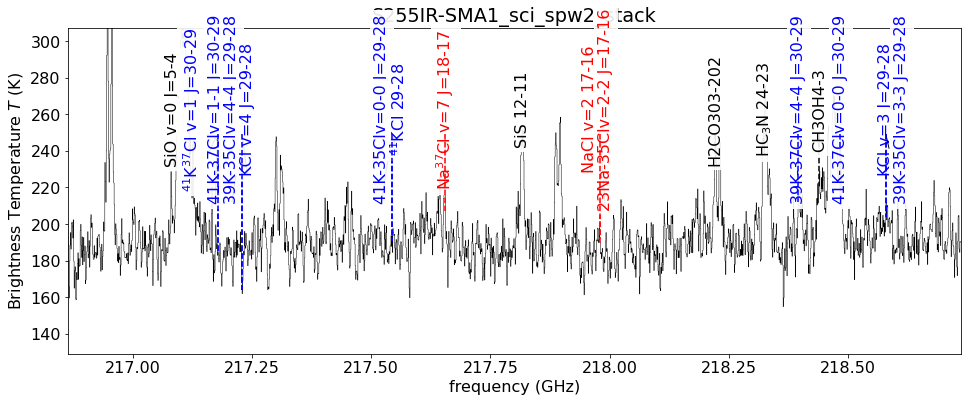

In [141]:
overplot_saltlines(stackspectra, vcen=0*u.km/u.s, savepath='spectra/figures')

In [142]:
ls spectra/figures/

color_labels_S255IR-SMA1_sci_cube_stack.png
color_labels_S255IR-SMA1_sci_spw0_stack.png
color_labels_S255IR-SMA1_sci_spw1_stack.png
color_labels_S255IR-SMA1_sci_spw2_stack.png
color_labels_S255IR-SMA1_sci_spw3_stack.png
color_labels_spw1.png
color_labels_spw2.png
color_labels_spw3.png
color_labels_spw4.png
S255IR-SMA1_sci_cube_stack.png
S255IR-SMA1_sci.spw0.cube.I.zoom.manual_stack.pdf
S255IR-SMA1_sci.spw0.cube.I.zoom.manual_stack.png
S255IR-SMA1_sci_spw0_stack.png
S255IR-SMA1_sci.spw1.cube.I.zoom.manual_stack.pdf
S255IR-SMA1_sci.spw1.cube.I.zoom.manual_stack.png
S255IR-SMA1_sci_spw1_stack.png
S255IR-SMA1_sci.spw2.cube.I.zoom.manual_stack.pdf
S255IR-SMA1_sci.spw2.cube.I.zoom.manual_stack.png
S255IR-SMA1_sci_spw2_stack.png
S255IR-SMA1_sci.spw3.cube.I.zoom.manual_stack.pdf
S255IR-SMA1_sci.spw3.cube.I.zoom.manual_stack.png
S255IR-SMA1_sci_spw3_stack.png
spw1.png
spw2.png
spw3.png
spw4.png


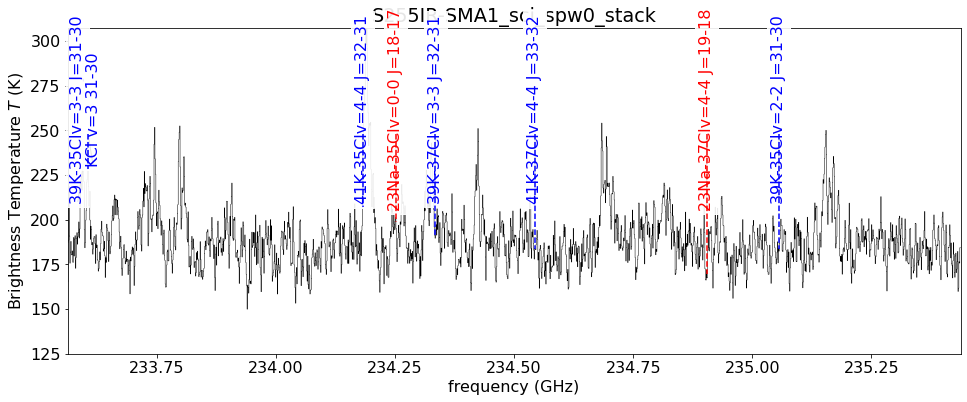

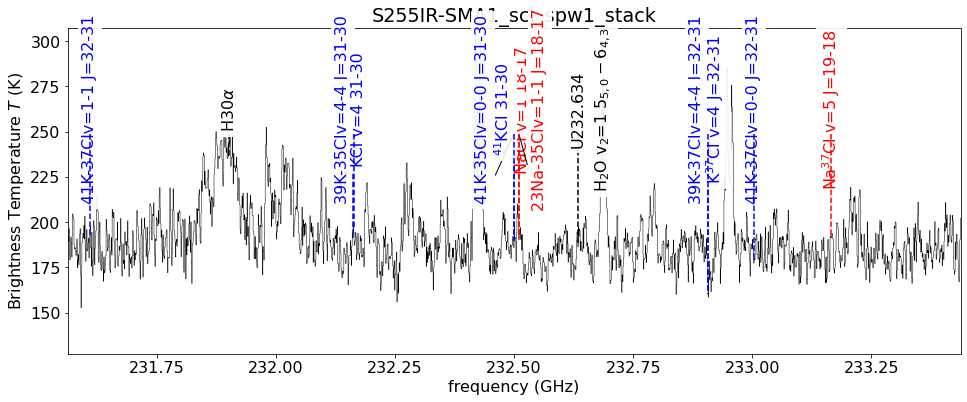

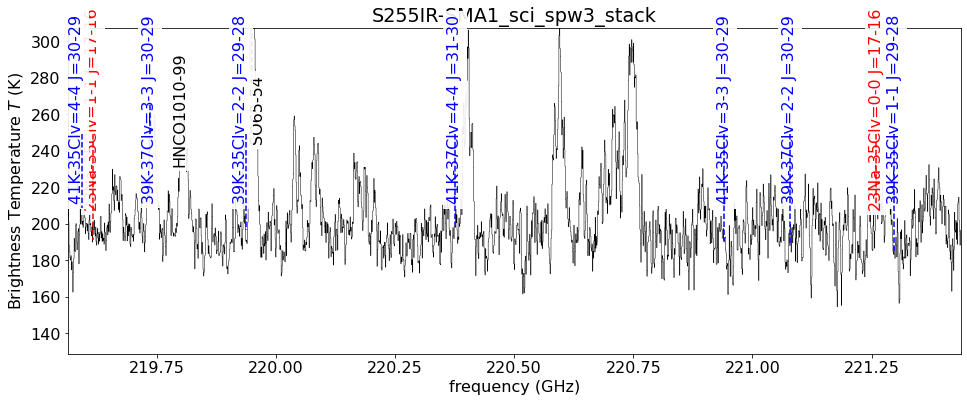

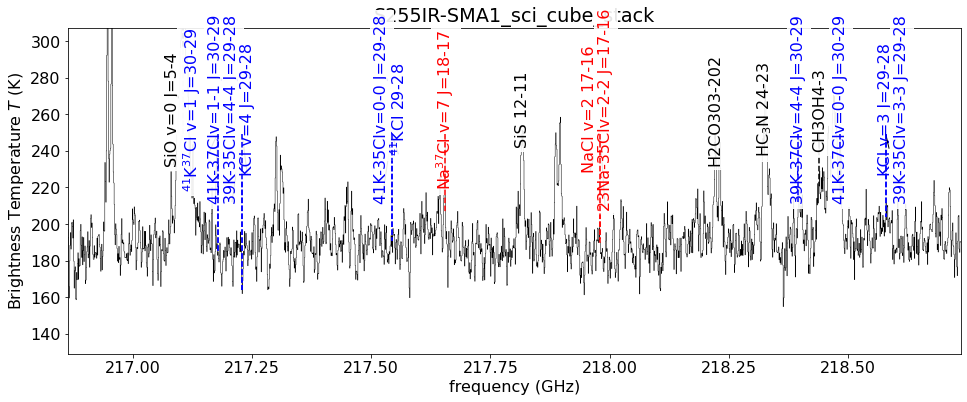

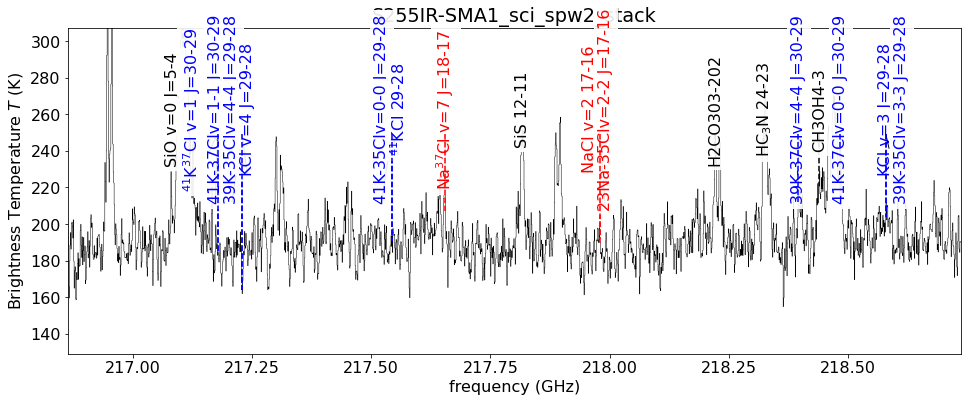

In [143]:
for fn in glob.glob('spectra/figures/color*stack.png'):
    display(Image(fn))

## 